#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Mean Reversion with Bollinger Bands  Strategy

This strategy was created to capture the type of largely sideways market we had in April and June 2020 for BTC. It uses Bollinger-bands indicators. 

The slow moving average will be optimized over a period of a few days, the fast moving average over the last couple of hours. The upper and lower bands are slow mva + - multiplier * slow std.

When the fast mva price breaches either the upper or lower band, the upper or lower-breached flag is switched on. When this fast mva comes back within the bands, we put on the corresponding short or long trade.

We take profit when the fast mva reaches the slow mva or if the unrealized profit is 4% or higher. We stop our losses when the unrealized loss surpasses 1.5%. These two parameters can also be optimized to a certain extent.

A couple data points are kept track of to help make sure the algorithm works as expected.

In [1]:
%load_ext zipline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import OrderedDict
from datetime import datetime, timedelta
import pytz

import zipline
from zipline.api import *
from zipline.utils.always_open import AlwaysOpenCalendar

import pyfolio as pf
import empyrical

In [3]:
data = OrderedDict()
data['BTC'] = pd.read_csv("data/btc_2019_aug6_2020.csv",index_col=0,parse_dates=True)

# Zipline only allows trading of whole number of any particular security.
# However, BTC is traded on exchanges in tiny fractions of a single Bitcoin. 
# To allow for realistic backtesting with Zipline, we rescaled the price and volume of BTC
muliplier = 100
data['BTC'].loc[:,'open':'close'] /= muliplier
data['BTC'].volume *= muliplier

panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

In [7]:
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')
    
    context.lower_breached = False
    context.upper_breached = False
    
    context.times_breaches = 0
    context.take_profit = 0
    context.stopped_out = 0
    context.orders_cancelled = 0
    context.pos_ret = 0
    context.neg_ret = 0
    
    context.long_window = 4080
    context.short_window = 330
    context.std_multiplier = 1.3
    context.pt = .04
    context.sl = -.012

def handle_data(context, data):
    
    price_history = data.history(
        context.security,
        fields='close',
        bar_count=context.long_window,
        frequency='1m'
    )
    current_price = price_history[-1]
    fast_mva = price_history[-context.short_window:].mean()
    
    slow_mva = price_history.mean()
    std_price = price_history.std()
    upper = slow_mva + context.std_multiplier*std_price
    lower = slow_mva - context.std_multiplier*std_price
    
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders)==0 else btc_orders[0].status==0
    filled_price = context.portfolio.positions[context.security].cost_basis
   
    # put on short trades
    if fast_mva > upper and not context.upper_breached:
        context.upper_breached = True
        context.times_breaches += 1
    elif not open_orders and not pos_amount and context.upper_breached and fast_mva <= upper:
        order_target_percent(context.security, -1, limit_price=fast_mva * .995)
        context.upper_breached = False
    
    # put on long trades
    elif fast_mva < lower and not context.lower_breached:
        context.lower_breached = True 
        context.times_breaches += 1
    elif not open_orders and not pos_amount and context.lower_breached and fast_mva >=lower:
        order_target_percent(context.security, 1, limit_price=fast_mva * 1.005)
        context.lower_breached = False 
    
    elif open_orders and btc_orders[0].status == 0 and get_datetime() - btc_orders[0].created >= timedelta(minutes=30):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1
    
    # take profits or stop loss for short trades
    elif not open_orders and pos_amount<0:
        prct_changed = (filled_price-current_price)/filled_price
        if fast_mva <= slow_mva:
            order_target_percent(context.security, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= context.pt:
                order_target_percent(context.security, 0)
                context.take_profit += 1
                context.pos_ret += 1
            elif prct_changed <= context.sl:
                order_target_percent(context.security, 0)
                context.stopped_out += 1
                context.neg_ret += 1
    
    # take profits or stop loss for long trades
    elif not open_orders and pos_amount>0:
        prct_changed = (current_price-filled_price)/filled_price
        if fast_mva >= slow_mva:
            order_target_percent(context.security, 0)
            if prct_changed >= 0.01:
                context.take_profit += 1
        else:
            if prct_changed >= context.pt:
                order_target_percent(context.security, 0)
                context.take_profit += 1
                context.pos_ret += 1
            elif prct_changed <= context.sl:
                order_target_percent(context.security, 0)
                context.stopped_out += 1
                context.neg_ret += 1
        
    # reset bands breached flags if price within range
    elif fast_mva > lower and fast_mva < upper and context.upper_breached+context.lower_breached:
        context.lower_breached = False
        context.upper_breached = False
        
    record(times_breached = context.times_breaches, stopped_out = context.stopped_out, 
           take_profits = context.take_profit, cancelled = context.orders_cancelled, 
           pos_ret = context.pos_ret, neg_ret = context.neg_ret)

In [8]:
perf = zipline.run_algorithm(start=datetime(2019, 6, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2019, 7, 31, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      handle_data=handle_data,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=20000,
                      data_frequency ='minute',
                      data=panel)

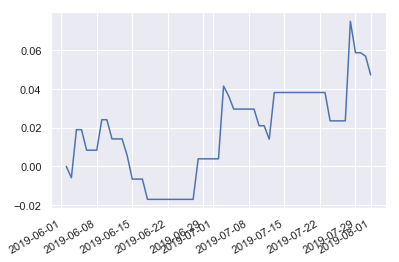

In [9]:
# with slow=4080, fast=330, mult=1.3
perf.algorithm_period_return.plot()

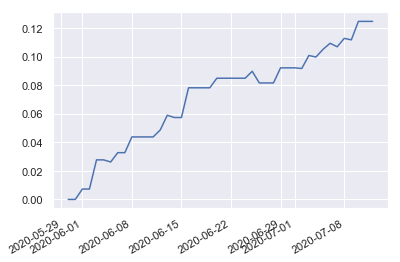

In [7]:
# with slow=2520, fast=240, mult=2
perf.algorithm_period_return.plot()